# Autoencoder Development

#### 1. Dependencies

This section could include:
* Library imports.
* Constant definitions

In [1]:
# library imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
from IPython.display import clear_output
import cv2

In [2]:
# detect if CUDA is available, if not use CPU
gpu_available = torch.cuda.is_available()

if gpu_available:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

#### 2. Data Loading & Feature Engineering

This section could include:

* Loading of data files
* Data manipulation
* Feature engineering strategies

In [3]:
# load images
images1 = np.load("subset_1.npy")
# images2 = np.load("subset_2.npy")
# images3 = np.load("subset_3.npy")

# images = np.array(list(images1) + list(images2) + list(images3))
# add padding
def pad(images):
    padded_images = []
    for i in range(len(images)):
        img = np.reshape(images[i], (150, 225, 3))
        padded = cv2.copyMakeBorder(img, 1, 1, 1, 2, borderType = cv2.BORDER_CONSTANT, value = [0, 0, 0])
        padded_images.append(padded)

    images = np.array(padded_images)
    return images

images = pad(images1)
# split into training and testing datasets & prepare for use by neural networks
num_images = images.shape[0]
training_samples = int((0.75 * num_images) // 1)

images = images.reshape(-1, 3, 152, 228)
np.random.shuffle(images)

train_data = images[:training_samples] / 255.
test_data = images[training_samples:] / 255.

train_data = torch.tensor(train_data, dtype = torch.float32)
test_data = torch.tensor(test_data, dtype = torch.float32)

#### 3. Model Development

This section could include:

* Model Definitions
* Hyperparameter Tuning
* Training code
* Optimisation

In [ ]:
# Handles creation of encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, *network_parameters):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.network_parameters = network_parameters
        # if network_parameters == ():
        #     self.network_parameters = None
        # else:
        #     self.network_parameters = network_parameters

        # If network parameters are provided, use them to create the model
        if self.encoder:
            self.encode = self.create_model()
            if self.network_parameters and len(self.network_parameters) == 2:
                self.encode.load_state_dict(torch.load(self.network_parameters[0], map_location = DEVICE))
            else:
                self.encode.to(DEVICE)
                
        else:
            self.decode = self.create_model()
            if self.network_parameters and len(self.network_parameters) == 2:
                self.decode.load_state_dict(torch.load(self.network_parameters[1], map_location = DEVICE))
            else:
                self.decode.to(DEVICE)

    
    def create_model(self):
        if self.encoder:
            model = nn.Sequential(
                nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 2, stride = 2, padding = 0),
                nn.LeakyReLU(0.01),

                nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 2, stride = 2, padding = 0),
            )
        else:
            model = nn.Sequential(
                nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 2, stride = 2, padding = 0),
                nn.LeakyReLU(0.01),

                nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 2, stride = 2, padding = 0),
                nn.Sigmoid()
            )
        
        return model

    # encode and decode methods, used by neural networks
    def enc(self, x):
        return self.encode(x)
    
    def dec(self, x):
        return self.decode(x)
    
    # encode and decode methods, used for application
    # takes an image as a numpy array (101250, ) and returns compressed data in a numpy array
    def encode_data(self, image):
        original_size = image.nbytes
        print("Original image size:", original_size / 1e6, "MB")
        image = np.reshape(image, (150, 225, 3)) / 255.
        image_data = cv2.copyMakeBorder(image, 1, 1, 1, 2, borderType = cv2.BORDER_CONSTANT, value = [0, 0, 0])
        image_data = image_data.reshape(3, 152, 228)
        data = torch.tensor(image_data, dtype = torch.float32)
        data = data.to(DEVICE)
        output = self.enc(data)
        output = output.cpu().detach().numpy().astype(np.float16)
        print("Compressed image size:", output.nbytes / 1e6, "MB")
        print("Compression ratio:", round(original_size / output.nbytes, 5))

        return output

    # takes compressed data in a numpy array and returns it as an image in a numpy array (3, 152, 228)
    def decode_data(self, data):
        data = torch.tensor(data, dtype = torch.float32)
        data = data.to(DEVICE)
        output = self.dec(data)
        output = output.cpu().detach().numpy()
        output_image = (output * 255).astype(np.uint8)
        output_image = np.reshape(output_image, (152, 228, 3))

        return output_image


#### 4. Model Evaluation

This section could include:

* Testing of models trained
* Generation of results

In [5]:
# Handels autoencoder training
class AutoencoderTrainer:
    def __init__(self, encoder, decoder, learning_rate):
        self.encoder = encoder
        self.decoder = decoder
        self.learning_rate = learning_rate
        self.loss_f = nn.MSELoss()
        self.optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = self.learning_rate)

    def autoencode(self, encoder, decoder, data):
        return decoder.dec(encoder.enc(data))

    def calculate_loss(self, output, target):
        loss = self.loss_f(output, target)
        return loss
    
    def update(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, epochs):
        for epoch in range(1, epochs + 1):
            for sample in train_data:
                sample = sample.to(DEVICE)
                output = self.autoencode(self.encoder, self.decoder, sample)  
                
                loss = self.calculate_loss(output, sample)
                self.update(loss)

            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    def test(self):
        outputs = []
        for sample in test_data:
            sample = sample.to(DEVICE)
            output = self.autoencode(self.encoder, self.decoder, sample)
            outputs.append(output)

        return outputs

In [6]:
# Create encoder and decoder
encoder = Autoencoder(True)
decoder = Autoencoder(False)

# Train autoencoder and decoder
lr = 0.0001 # 0.0001
epochs = 1 # 100
trainer = AutoencoderTrainer(encoder, decoder, lr)
trainer.train(epochs)

Epoch: 1, Loss: 0.1433330625295639


In [7]:
# neural network structure
print(encoder)
print(decoder)

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(3, 9, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(9, 27, kernel_size=(2, 2), stride=(2, 2))
  )
)
Autoencoder(
  (decode): Sequential(
    (0): ConvTranspose2d(27, 9, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(9, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


Original image size: 0.10125 MB
Compressed image size: 0.116964 MB
Compression ratio: 0.86565


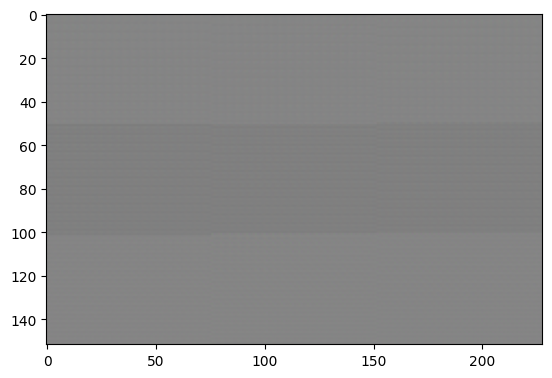

In [8]:
# images = np.load("subset_1.npy")
# images = np.load("subset_2.npy")
images = np.load("subset_3.npy")

i = np.random.randint(0, len(images))
img = images[i]

encoded = encoder.encode_data(img)
decoded = decoder.decode_data(encoded)
plt.imshow(decoded)

#### 5. Figure Creation

This section could include:

* Creation of figures for the report.
* Creationg of tables for the report.

In [9]:
# process images through autoencoder
imgs = trainer.test()

for i in range(len(imgs)):
    imgs[i] = (imgs[i].detach().cpu().numpy() * 255).astype(np.uint8)
    imgs[i] = np.reshape(imgs[i].flatten(), (152, 228, 3))

print(imgs[0].shape)

(152, 228, 3)


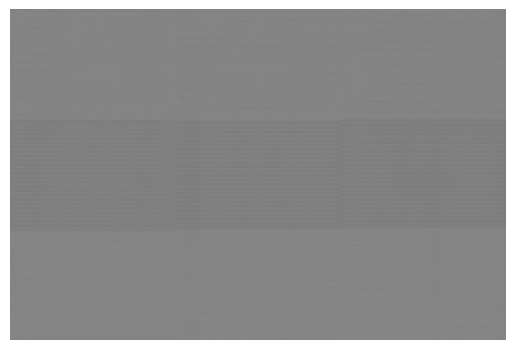

[24, 59, 76, 51, 82]


In [10]:
# display original image then autoencoded image (1 second delay)
image_indexes = []
for i in range(5):
    num = np.random.randint(0, len(test_data) - 1)
    image_indexes.append(num)
    clear_output(wait = True)
    plt.imshow(np.reshape((test_data[num].numpy() * 255).astype(np.uint8), (152, 228, 3)))
    plt.axis("off")
    plt.show()
    time.sleep(1)
    clear_output(wait = True)
    plt.imshow(imgs[num])
    plt.axis("off")
    plt.show()
    time.sleep(1)
print(image_indexes)

In [11]:
# Compare a specific image vs autoencoded image from the test dataset
IMAGE_NUMBER = 10

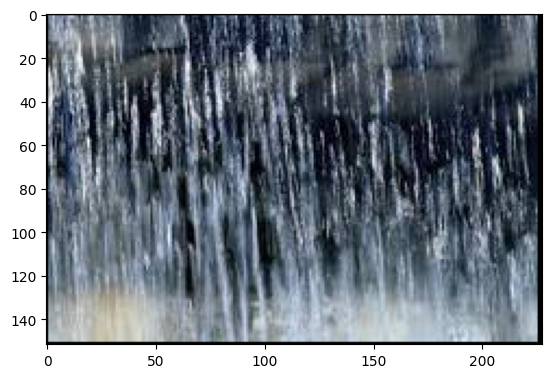

In [12]:
plt.imshow(np.reshape((test_data[IMAGE_NUMBER].numpy() * 255).astype(np.uint8), (152, 228, 3)))

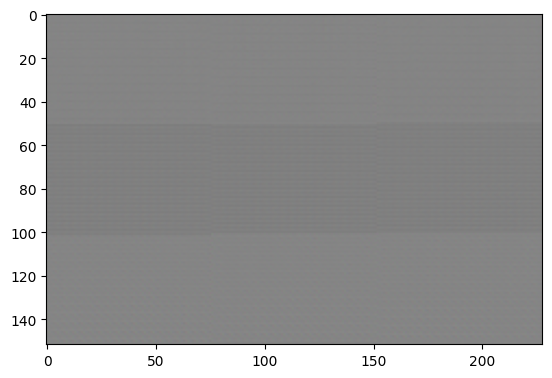

In [13]:
[plt.imshow(imgs[IMAGE_NUMBER])]

In [14]:
# 2
# Autoencoder(
#   (encode): Sequential(
#     (0): Conv2d(3, 8, kernel_size=(2, 2), stride=(2, 2))
#     (1): LeakyReLU(negative_slope=0.01)
#     (2): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
#   )
# )
# Autoencoder(
#   (decode): Sequential(
#     (0): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
#     (1): LeakyReLU(negative_slope=0.01)
#     (2): ConvTranspose2d(8, 3, kernel_size=(2, 2), stride=(2, 2))
#     (3): Sigmoid()
#   )
# )

# encoder_parameters = torch.save(encoder.encode.state_dict(), "encoder_parameters_overfitted.pth")
# decoder_parameters = torch.save(decoder.decode.state_dict(), "decoder_parameters_overfitted.pth")